In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import torch_tensorrt

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, cohen_kappa_score
from collections import deque
import pandas as pd
import math


import sys
sys.path.append('..')
from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [2]:
df = create_merged_game_data_df(['ranked','mango','public'])

In [3]:
df.columns


Index(['source', 'source_path_prefix', 'source_path_suffix', 'length',
       'num_players', 'is_teams', 'player_1_port', 'player_1_character_name',
       'player_1_type_name', 'player_1_stocks', 'player_1_costume',
       'player_1_team_value', 'player_1_ucf_shield_drop_name', 'player_1_tag',
       'player_1_display_name', 'player_2_port', 'player_2_character_name',
       'player_2_type_name', 'player_2_stocks', 'player_2_costume',
       'player_2_team_value', 'player_2_ucf_shield_drop_name', 'player_2_tag',
       'player_2_display_name', 'random_seed', 'slippi', 'stage_name',
       'is_pal', 'is_frozen_ps', 'end_method_name', 'lras_initiator',
       'conclusive', 'winning_player', 'date', 'duration', 'platform',
       'player_1_netplay_code', 'player_1_netplay_name',
       'player_2_netplay_code', 'player_2_netplay_name', 'console_name',
       'all_data_df_common_path', 'inputs_df_common_path',
       'inputs_np_common_path', 'player_1_all_data_df_sub_path',
       'player_

In [4]:
df['player_1_display_name'].value_counts()

                   99186
Platinum Player    47335
Master Player      39195
Diamond Player     29613
mang               14142
                   ...  
AV                     1
Zuppy                  1
tk                     1
DawsonTruu             1
Bink                   1
Name: player_1_display_name, Length: 257, dtype: int64

In [5]:
df['length'].sum() / (60)

41459841.06666667

In [6]:
def asses_model(model_name, y_pred, y_test, labels_order):
    print()
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_pred, y_test)

    # Print accuracy and Cohen Kappa score with explanations
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

    # Calculate the normalized predicted label count
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
    # Calculate the percent the model over or under predicted the labels using the specified label order
    sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

    # Plotting the percent the model over or under predicted the labels
    plt.figure(figsize=(2*len(labels_order), 4))
    plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Percent Over/Under Prediction')
    
    # Center y-axis and set equal extension above and below
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # Display each confusion matrix on its own row
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize=norm, ax=ax,
            xticks_rotation='vertical', labels=labels_order
        )
        ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
        plt.tight_layout()
        plt.show()
        



In [7]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [8]:
# source_data = ['ranked','public']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     # 'netplay_code': ['MANG#0'],
#     # 'character_name': ['PICHU'],
#     # 'character_name': ['PIKACHU'],
#     # 'character_name': ['PIKACHU','PICHU'],
#     # 'character_name': ['FOX','FALCO'],
#     'character_name': ['FOX','FALCO','PIKACHU','PICHU'],
#     # 'display_name': ['Platinum Player','Master Player', 'Diamond Player']

    
# }
# opposing_player_features = {
#     # 'character_name': ['MARTH'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0']
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['player'], # Can be 'general', 'player
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }

In [9]:
# # We classify opponent's characters on competitive stages

# source_data = ['ranked']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     # 'netplay_code': ['MANG#0'],
#     'character_name': ['FOX'],
#     'type_name': ['HUMAN']
    
# }
# opposing_player_features = {
#     'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['opposing_player'], # Can be 'general', 'player', 'opposing_player'
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }
    

In [10]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())

/workspace/slp_jaspar/autoencoder_classify/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
Name: labels, dtype: int64


In [11]:
labels_order =  dataset.number_of_segments_per_game(3600,50000)
print(2**10)
print(labels_order)
labels_order = labels_order['Label'].values


1024
            Label   Count  Shift
0             FOX  102551  12060
1           FALCO   90263  10395
2           MARTH   53538   6856
3  CAPTAIN_FALCON   37820   4325
4           SHEIK   27536   3960


In [12]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\FALCO\36f26f20-69c4-44d4-af3e-efb31c3d7...   13993             1   
1  public\FALCO\06dd9407-d2e9-4d36-b0fb-9ea92d55d...   13992             1   
2  public\FALCO\c7d682a2-d6d6-46b0-a681-ecebfdd17...   13991             1   
3  ranked\FALCO\6108373e-a968-41b9-82a7-25b330bc2...   13990             1   
4  ranked\FALCO\bd31d158-9661-4999-84a9-08ec9653c...   13986             1   

  labels  encoded_labels  
0  FALCO               1  
1  FALCO               1  
2  FALCO               1  
3  FALCO               1  
4  FALCO               1  


In [13]:
# train_df, test_df = dataset.all_segments_train_test_split_dataframes(3600, proportion_of_segments=1, test_ratio = .2, val = False)
# porportion = 1
# train_df = train_df.sample(frac=porportion, random_state = 42)
# porportion = .05
# test_df = test_df.sample(frac=porportion, random_state = 42)
print(train_df.shape)
print(test_df.shape)
# print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))
train_df.head()

(200000, 6)
(50000, 6)


,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,ranked\FALCO\7646b650-1713-4ae9-9983-12b15a4d1...,FALCO,1,0,0,3600
1,ranked\FALCO\2d9c2cf8-dd1e-4134-a832-caaca1398...,FALCO,1,0,0,3600
2,ranked\FALCO\62f3e3ef-fa50-4f50-bfc3-d5db83e26...,FALCO,1,0,0,3600
3,ranked\FALCO\ffed045e-97a1-429e-8ceb-22fc411d6...,FALCO,1,0,0,3600
4,ranked\FALCO\0504f129-2fdd-4916-a61e-923672508...,FALCO,1,0,0,3600


In [14]:
labels_unique = train_df['labels'].unique()
encoded_labels_unique = train_df['encoded_labels'].unique()
label_decoder = zip(labels_unique, encoded_labels_unique)
label_decoder = dict(zip(encoded_labels_unique, labels_unique)) 
print(label_decoder)

{1: 'FALCO', 3: 'MARTH', 2: 'FOX', 0: 'CAPTAIN_FALCON', 4: 'SHEIK'}


In [15]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        

        segment[-5] = (segment[-5] > .5)
        
        if self.transform:
            transformed = np.zeros((9 + 5+4,3600))
            
            # First 4 rows of transformed are the analog inputs transformed to have range [0,1]
            # Shift inputs: adjusting so that positives are reduced and negatives are increased
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
            analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
            # Scale inputs to be between -.5 and .5
            analog_transformed *= .5 / .725
            # Add .5 to so final inputs are between 0 and 1
            analog_transformed += .5
            
            transformed[0:4] = analog_transformed
            # Next four rows are 1 if the corresponding analog input is 0
            transformed[4:8] += (segment[:4] == 0)
            
            
            prepend = np.expand_dims(segment[-5:, 0], axis=1)
            transitions= np.abs(np.diff(segment[-5:], axis=1, prepend=prepend))
            
            transformed[8:13] += transitions
            
            

            # Transform the Trigger so that it is 0 or 1
            
            
            # Remaining rows are button inputs
            transformed[-5:] += segment[-5:]
            
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(transformed).float()
        label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df,True)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df,True)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True, drop_last=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True, drop_last=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [16]:
@torch.jit.script
def split_batches_of_minute_segments(batch):
    num_channels = 18
    chunks = torch.split(batch, 1, 0)
    list0 = [torch.stack(torch.split(chunk.view(num_channels, 3600), 60, 1), dim=0) for chunk in chunks]
    new_batch = torch.cat(list0,dim=0)
    # print('new_batch',new_batch.shape)
    return new_batch

@torch.jit.script
def merge_seconds_to_minute(encoded):
    # batch_size = 16
    # print(encoded.shape)
    # chunks = torch.split(encoded, 1, 0)
    # print('chunks[0].shape',chunks[0].shape)
    # print('len(chunks)',len(chunks))
    # list = [torch.stack(chunks[i*60: i*60 + 60]) for i in range(batch_size)]
    # print('list[0].shape',list[0].shape)
    # encoded_batch = torch.cat(list, dim=0)
    # print('encoded_batch.shape',encoded_batch.shape)
    chunks = torch.split(encoded,1,0)
    list0 = []
    # print(chunks[0].shape)
    for chunk in chunks:
        chunk = chunk.view(chunk.size(1), chunk.size(2))
        # print(chunk.shape)
        list0.append(chunk)
    list1=[]
    # print(len(list0))
    # print(list0[0].size)
    for i in range(16):
        list1.append(torch.cat(list0[i*60:i*60+60],dim=1))
    # print(len(list1))
    # print(list1[0].shape)
    final = torch.stack(list1)    
    # print(final.shape)
    return final
    
    

In [17]:

def train_model_with_virtual_epochs(model, criterion, optimizer, loaders, device, encoder, num_epochs=1):
    # print(0)
    scaler = GradScaler()
    best_loss = float('inf')
    best_model = None
    
    vepoch_total = 0
    vepoch_loss_sum = 0
    best_vepoch_loss = float('inf')
    early_stopping_patience = 0
    encoder.eval()
    # print(1)
    for epoch in range(num_epochs):
        model.train()
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        virtual_epoch_start_time = time.time()

        # Initialize variables for tracking gradient and parameter stats
        grad_max = float('-inf')
        grad_min = float('inf')
        param_max = float('-inf')
        param_min = float('inf')
        # print(2)
        for inputs_cpu, labels in train_loader_tqdm:
            optimizer.zero_grad()
            batch_to_encode = split_batches_of_minute_segments(inputs_cpu)
            batch_to_encode_gpu = batch_to_encode.to(device)
            encoded_gpu = encoder(batch_to_encode_gpu)
            encoded_inputs_gpu = merge_seconds_to_minute(encoded_gpu)

            
            
            # optimizer.zero_grad()
            # print(encoded_inputs_gpu.shape)
            output_gpu = model(encoded_inputs_gpu)
            # output_gpu = model(inputs_cpu.to(device))
            # print(output_gpu.shape)
            loss = criterion(output_gpu, labels.to(device)) 
            # print(output_gpu)
            # print(labels)
            # print(loss)
            loss.backward()
            # scaler.scale(loss).backward()

            # Track max and min of gradients
            batch_grad_max = max((p.grad.max().item() for p in model.parameters() if p.grad is not None), default=grad_max)
            batch_grad_min = min((p.grad.min().item() for p in model.parameters() if p.grad is not None), default=grad_min)
            grad_max = max(grad_max, batch_grad_max)
            grad_min = min(grad_min, batch_grad_min)

            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            # scaler.step(optimizer)
            # scaler.update()

            vepoch_total += 1
            vepoch_loss_sum += loss.item()

            if time.time() - virtual_epoch_start_time > 30:
                vepoch_loss = vepoch_loss_sum / vepoch_total
                if best_vepoch_loss > vepoch_loss:
                    best_vepoch_loss = vepoch_loss
                else:
                    early_stopping_patience += 1

                # Calculate max and min of model parameters at the end of the virtual epoch
                param_max = max(p.data.max().item() for p in model.parameters())
                param_min = min(p.data.min().item() for p in model.parameters())

                train_loader_tqdm.set_postfix(
                    Best=f'{best_vepoch_loss:.10f}',
                    Vepoch=f'{vepoch_loss:.10f}',
                    patience=early_stopping_patience,
                    Grad_Max=grad_max,
                    Grad_Min=grad_min,
                    Param_Max=param_max,
                    Param_Min=param_min
                )
                # print('Grad Max:', grad_max, ' Grad Min:', grad_min)
                virtual_epoch_start_time = time.time()
                vepoch_total = 0
                vepoch_loss_sum = 0
                grad_max = float('-inf')  # Reset for next virtual epoch
                grad_min = float('inf')   # Reset for next virtual epoch
            # break

    return best_model

def predict(model, test_loader, device):
    """
    Evaluates the model on the test dataset and returns predictions as a numpy array,
    displaying a progress bar during the evaluation.

    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to evaluate on.

    Returns:
        numpy.ndarray: Numpy array of predictions.
    """
    model.eval()
    predictions = []
    # Initialize tqdm progress bar
    pbar = tqdm(total=len(test_loader), desc="Evaluating", leave=False)

    with torch.no_grad():
        for inputs, labels in test_loader:
            batch_to_encode = split_batches_of_minute_segments(inputs)
            batch_to_encode_gpu = batch_to_encode.to(device)
            encoded_gpu = encoder(batch_to_encode_gpu)
            encoded_inputs_gpu = merge_seconds_to_minute(encoded_gpu)
            
            # inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(encoded_inputs_gpu)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())  # Collecting predictions

            # Update the progress bar
            pbar.update(1)

    pbar.close()  # Ensure the progress bar is closed after the loop
    return predictions


In [18]:

from Encode_ResNet_Model import ResNet50, ResNet101
from Simple_Test_Model import Model
from autoencoder_classify.Convolutional_Encoder_Model import ResNet_Encoder

channels = 18
batch_size = 16
num_classes = 5
model = ResNet50(num_classes=5, channels=15).to('cuda')

# model = Model()
# model = torch.compile(model, mode = 'default')
model = torch.compile(model,mode = 'max-autotune')



channels = 9 + 5 + 4
# Build model
encoder = ResNet_Encoder(channels)
encoder.load_state_dict(torch.load('../../melee_project_data/convolutional_autoencode_bottlenecksize_15_resnet_weights_2.pt'))
encoder.to('cuda')

# Set the model to evaluation mode

# Optimize the loaded model with Torch-TensorRT
# encoder = torch_tensorrt.compile(
#     encoder,
#     inputs=[torch_tensorrt.Input((batch_size * 60, channels, 60))],
#     enabled_precisions={torch.float}  # Use torch.half for FP16 precision if needed
# )
## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')


encoder = torch.compile(encoder, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')

# Move the optimized model to GPU
# trt_encoder = trt_encoder.cuda()


In [19]:
batch_size =  16
num_workers = 16
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)
criterion = nn.CrossEntropyLoss()

Epoch 1/1:   0%|          | 0/12500 [00:00<?, ?batch/s]INFO:torch_tensorrt.dynamo.utils:Using Default Torch-TRT Runtime (as requested by user)
INFO:torch_tensorrt.dynamo.utils:Device not specified, using Torch default current device - cuda:0. If this is incorrect, please specify an input device, via the device keyword.
INFO:torch_tensorrt.dynamo.utils:Compilation Settings: CompilationSettings(precision=torch.float32, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_long_and_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.DEFAULT: 0>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_glob


Accuracy of ResNet-50: 0.8330
Cohen Kappa Score of ResNet-50: 0.7913


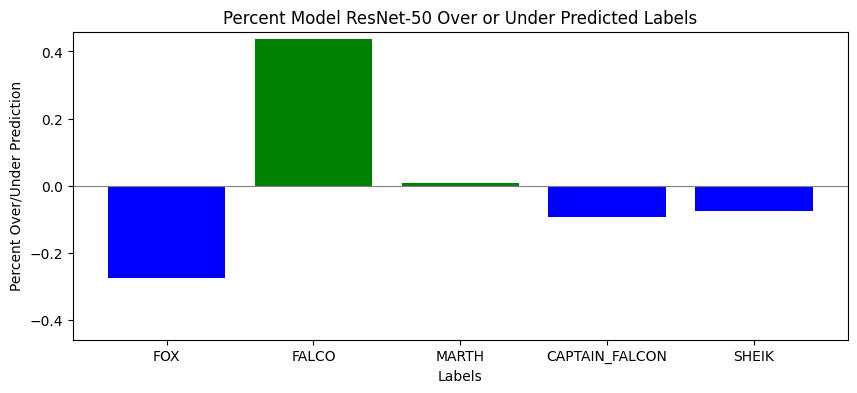

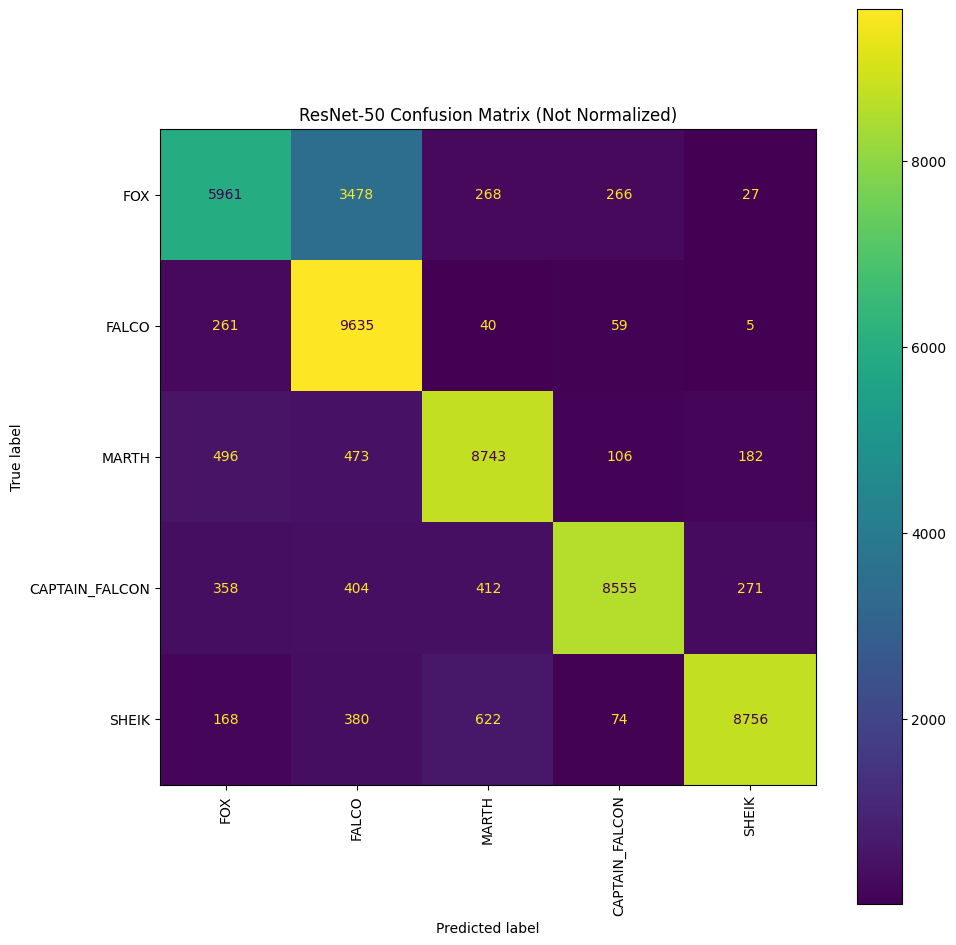

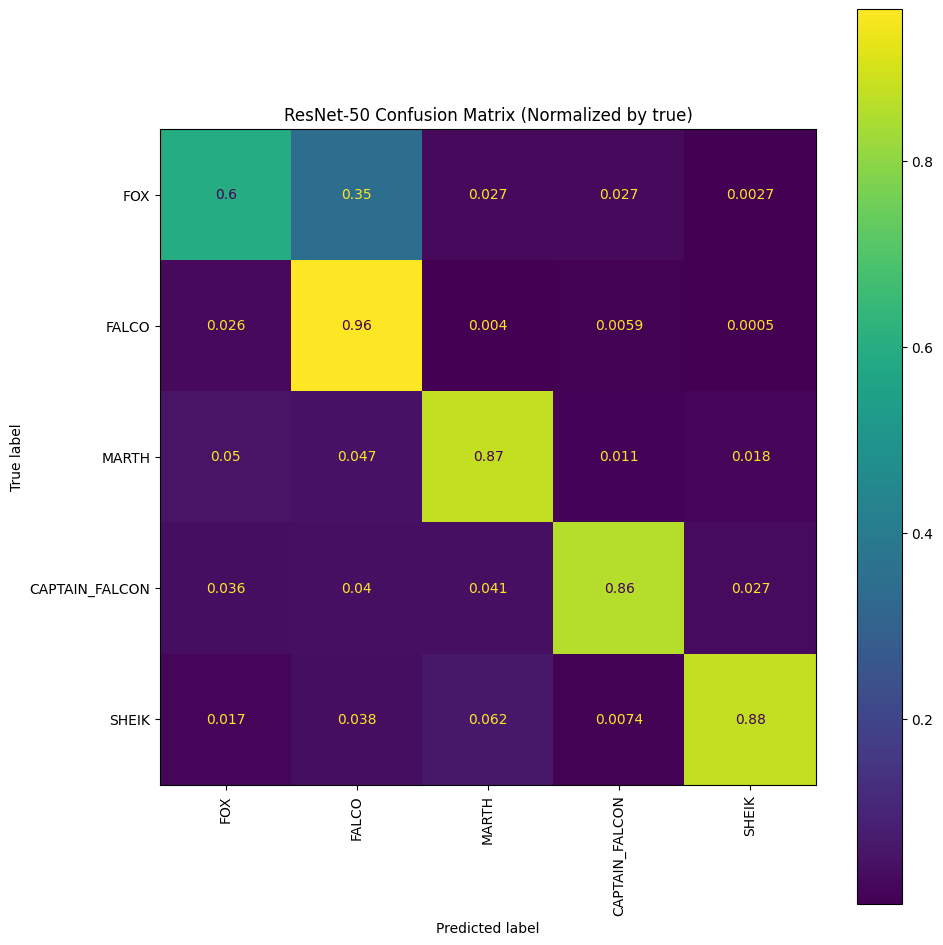

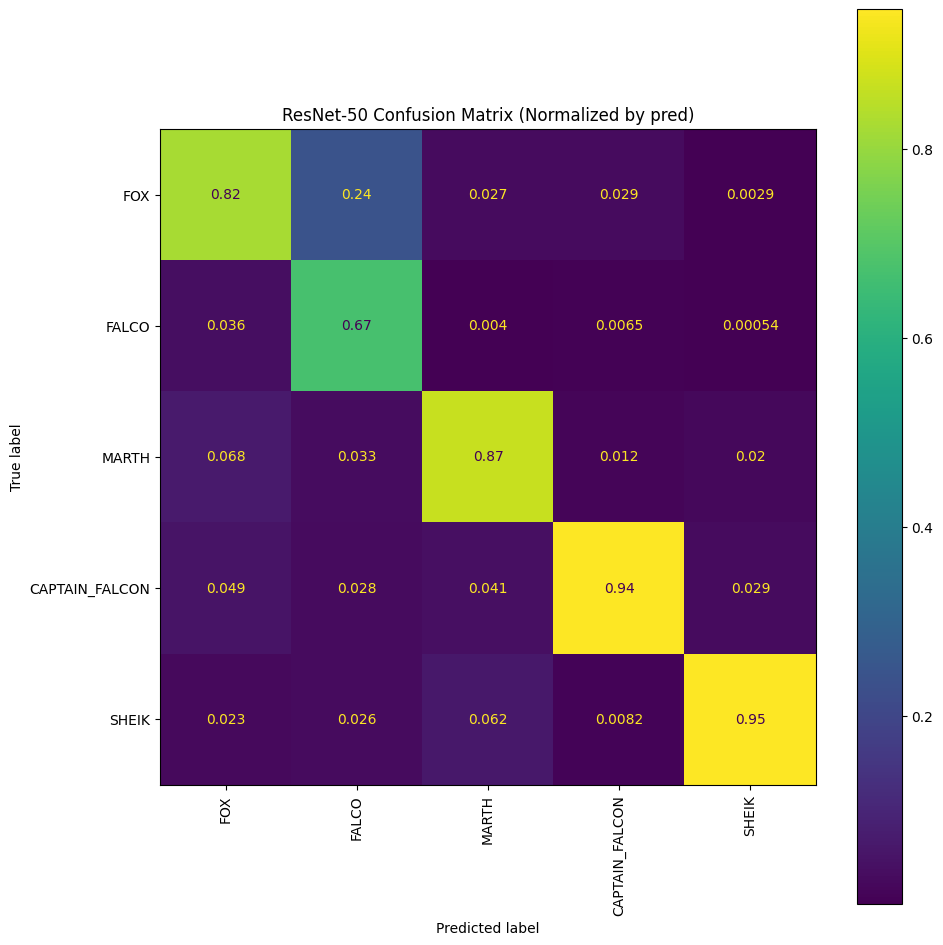

In [20]:
num_epochs = 1
optimizer = Adam(model.parameters(), lr=0.0001)
gc.collect()
torch.cuda.empty_cache()
# print(5)
train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', encoder, num_epochs)
y_pred = predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)


In [21]:
# asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)


In [22]:
# slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
# 
# y_pred = predict(model, loaders['test'], 'cuda' )



In [23]:
# print(test_df.shape)
# print(len(y_pred))

In [24]:
# asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)

In [25]:
num_epochs = 3
optimizer = Adam(model.parameters(), lr=0.0001)
gc.collect()
torch.cuda.empty_cache()
# print(5)
train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', encoder, num_epochs)
y_pred = predict(model, loaders['test'], 'cuda' )


Epoch 3/3: 100%|██████████| 12500/12500 [04:30<00:00, 46.22batch/s, Best=0.1738443325, Grad_Max=2.68, Grad_Min=-3.53, Param_Max=1.14, Param_Min=-0.27, Vepoch=0.1738443325, patience=8] 



Accuracy of ResNet-50: 0.9515
Cohen Kappa Score of ResNet-50: 0.9394


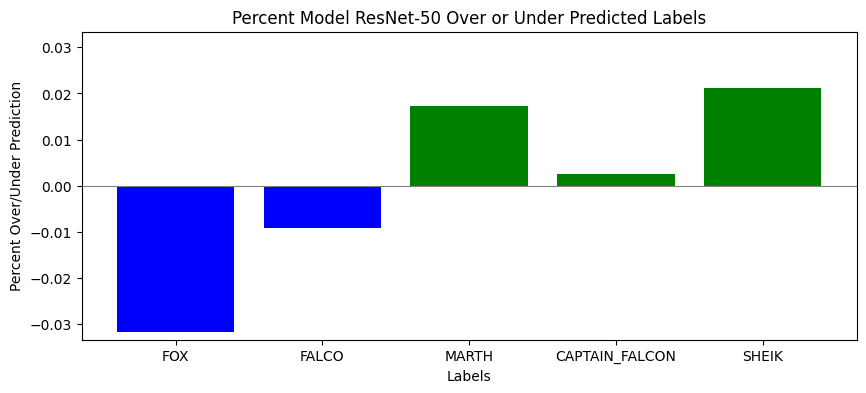

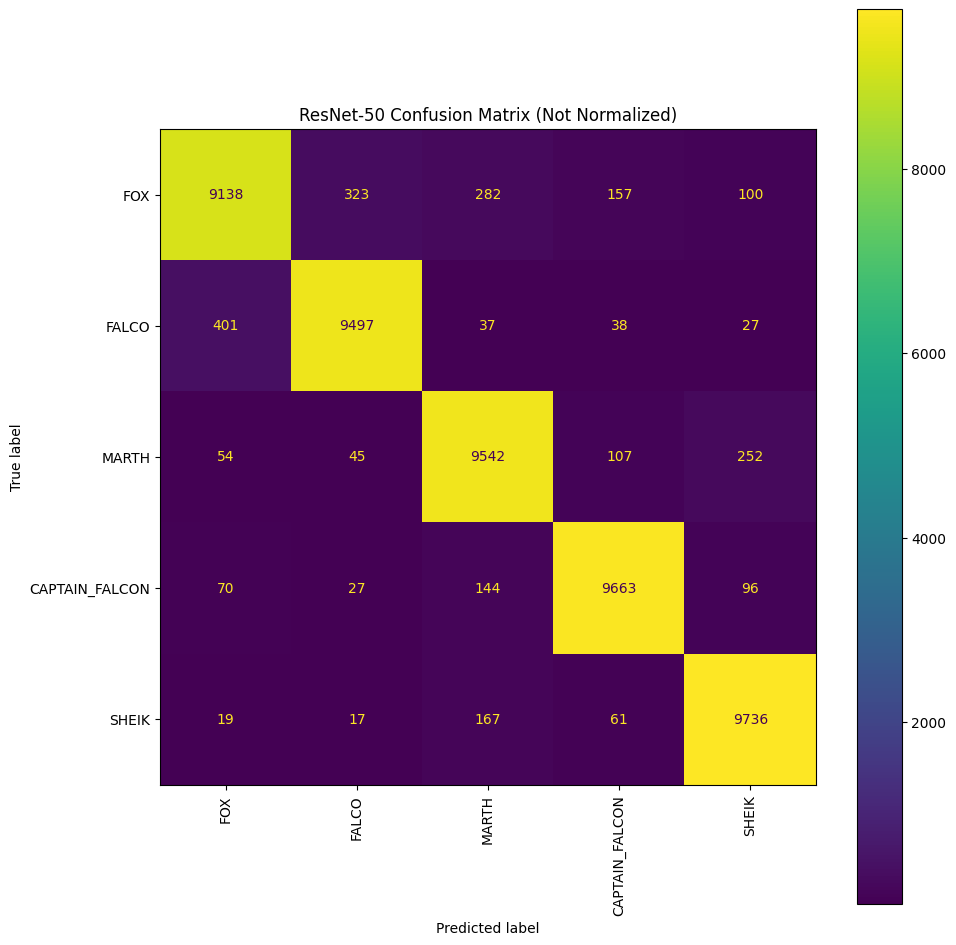

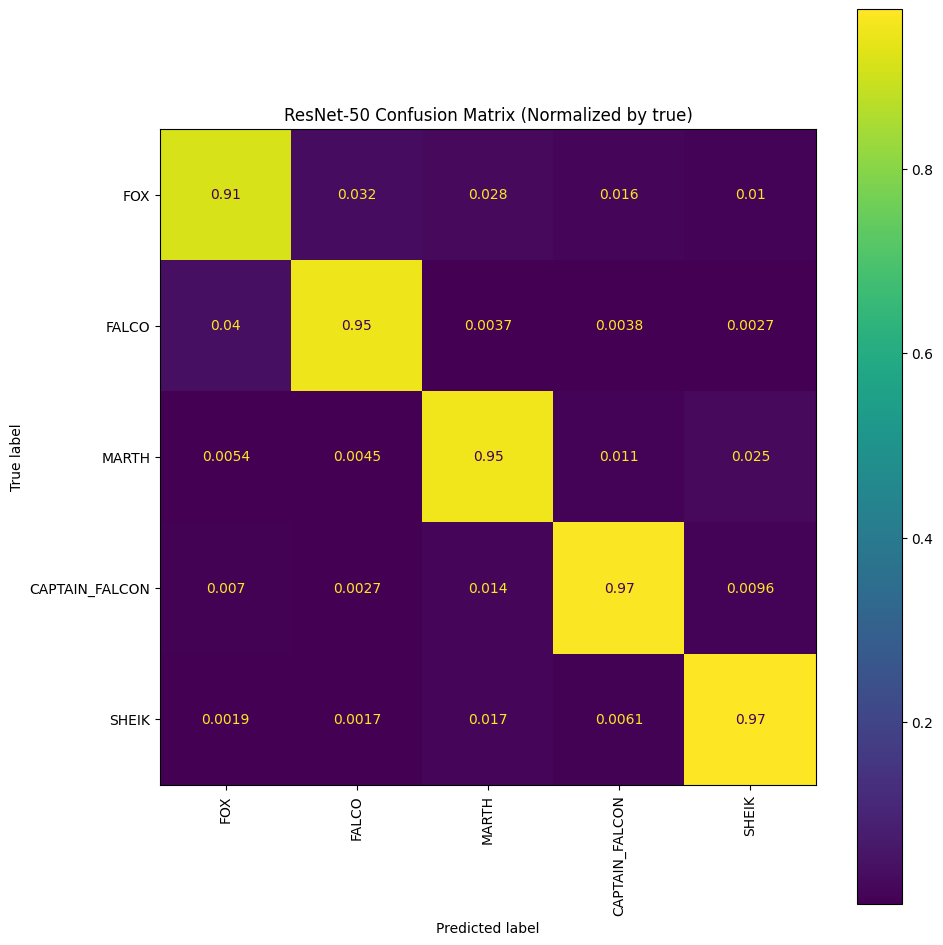

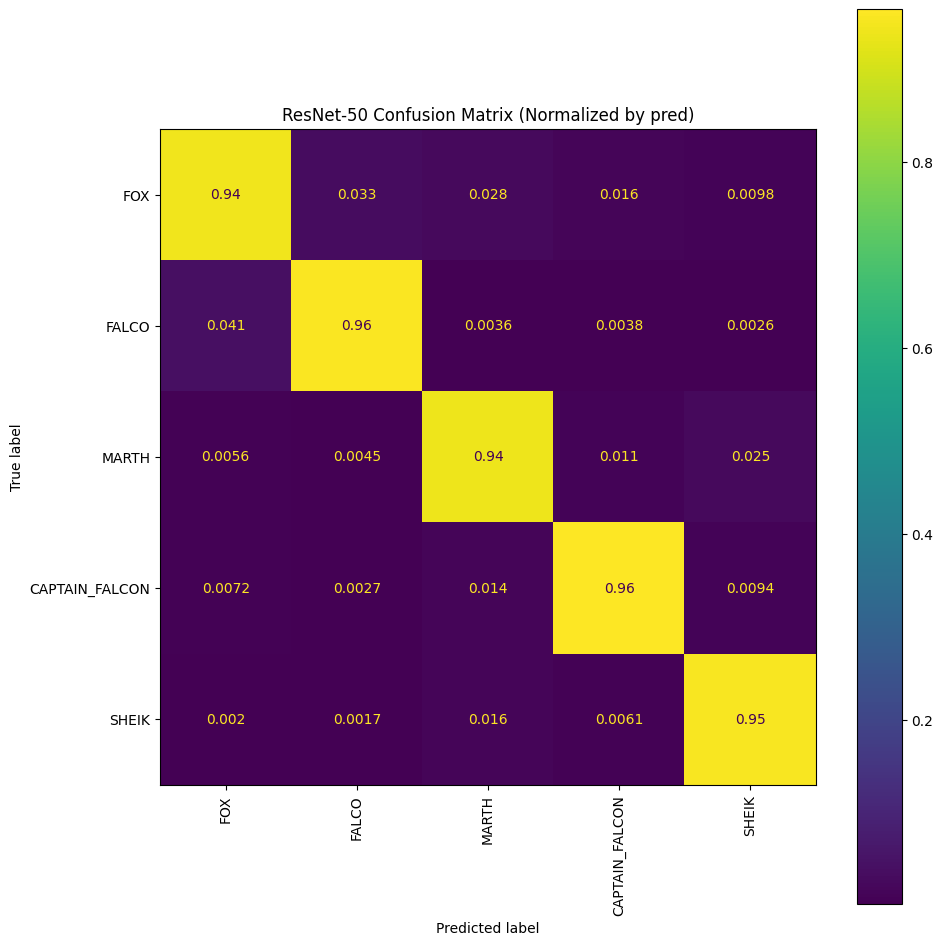

In [26]:

asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)


Epoch 3/3: 100%|██████████| 12500/12500 [04:28<00:00, 46.53batch/s, Best=0.0687438818, Grad_Max=5.32, Grad_Min=-4.33, Param_Max=1.14, Param_Min=-0.272, Vepoch=0.0721015369, patience=14]



Accuracy of ResNet-50: 0.9642
Cohen Kappa Score of ResNet-50: 0.9552


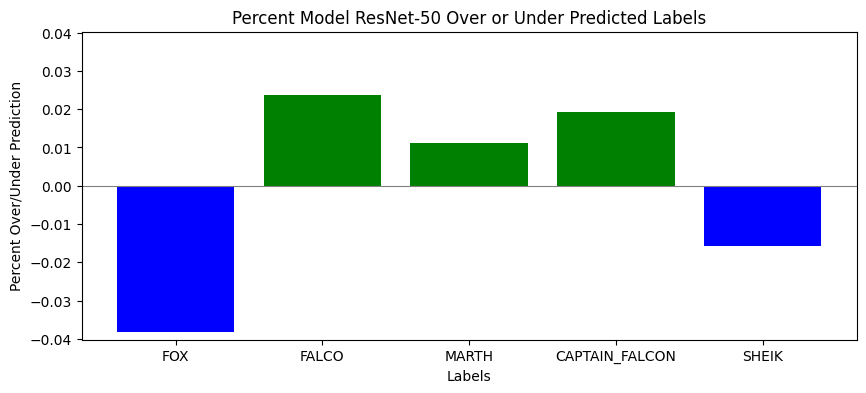

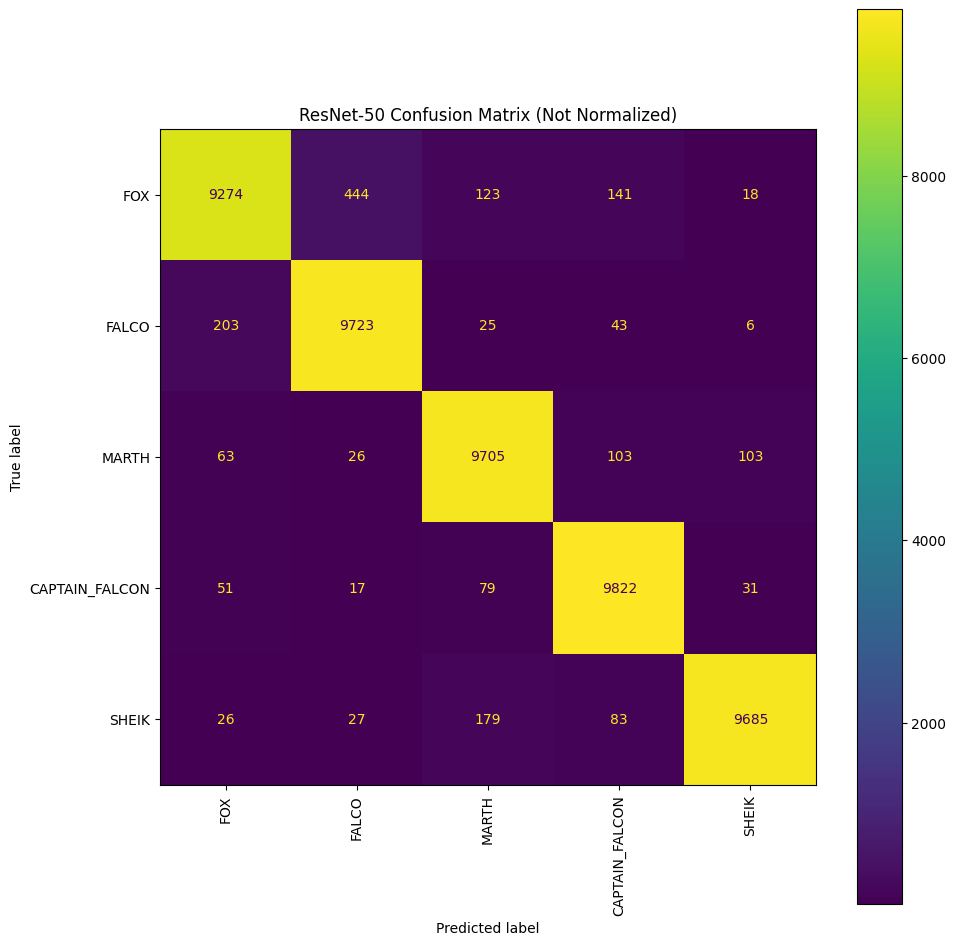

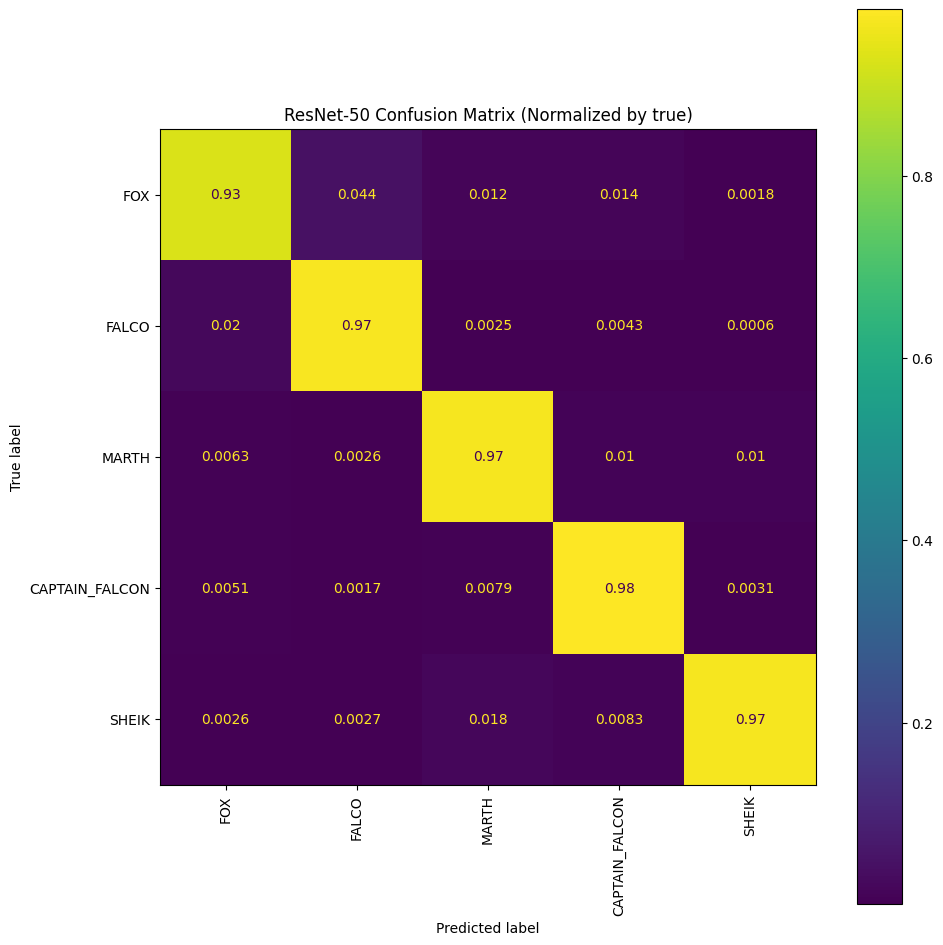

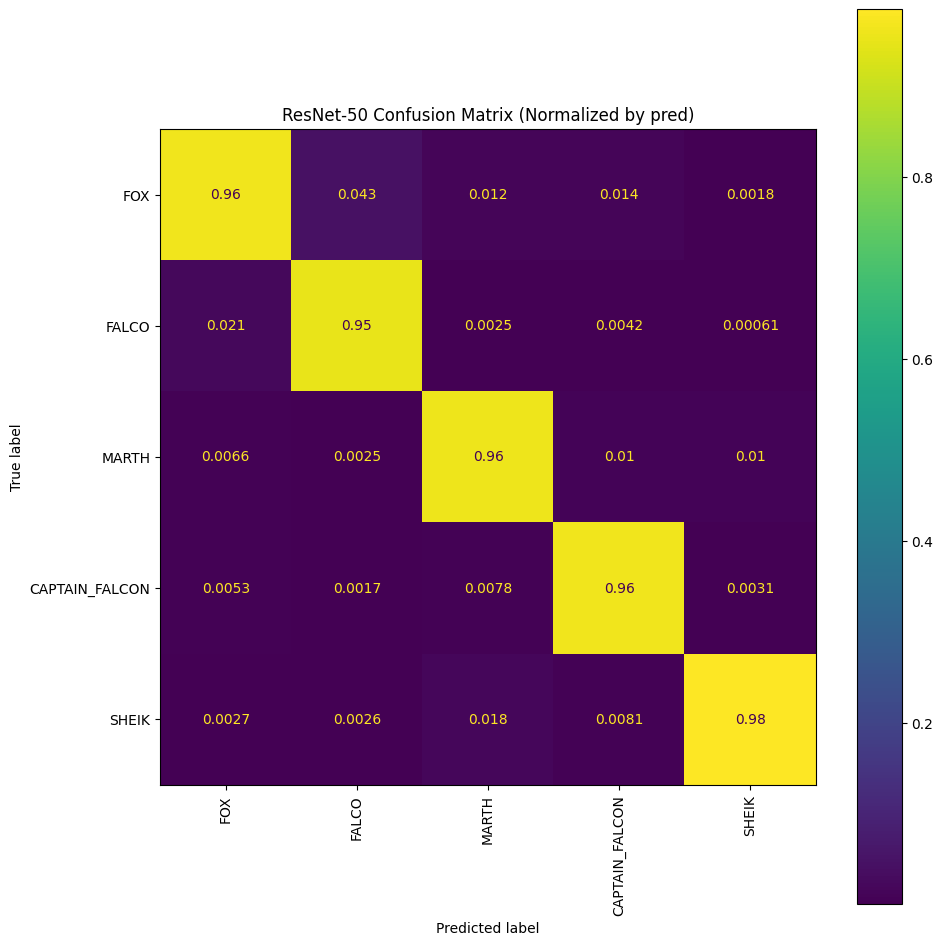

In [27]:
optimizer = Adam(model.parameters(), lr=0.00001)
gc.collect()
torch.cuda.empty_cache()
# print(5)
train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', encoder, num_epochs)
y_pred = predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)